In [1]:
from implicit.ResNetModel import ResNetModel
from implicit.Model import SequentialBlockModel
import time
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import scipy.sparse as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ResNet20 error: 7.17% surprisingly low for this model
resume = '/home/beeperman/Projects/ImplicitLayers/implicit/validation/save_temp/ResNet20model.th'
model = ResNetModel([3,3,3])

# ResNet56
#resume = '/home/beeperman/Projects/ImplicitLayers/implicit/validation/save_temp/ResNet56model.th'
#ResNetModel([9,9,9])

INFO: <function FlattenOpL.__init__.<locals>.<lambda> at 0x7f55eb2ceef0> is not a torch Module


In [3]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, m):
        super().__init__()
        self.module = m
        self.add_module("module", m)
        self.A = None; self.B = None; self.C = None; self.D = None; self.phi = None

    def forward(self, x):
        return self.module(x)

    def implicit_forward(self, x):
        if self.A is None:
            self.module.seqmodel.populate_C = True
            self.A, self.B, self.C, self.D, self.phi = self.module.seqmodel.getImplicitModel(x[0:1, :])
            self.A = sp.csr_matrix(self.A)

        out = SequentialBlockModel.implicit_forward(self.A, self.B, self.C, self.D, self.phi, x)
        out1 = torch.Tensor(out)
        out2 = self.forward(x)
        print("norm diff for the batch: {}".format(torch.norm(out2 - out1)))
        out2.copy_(out1)
        return out2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False)

print("=> loading checkpoint '{}'".format(resume))
checkpoint = torch.load(resume)
model = ModelWrapper(model)
model.load_state_dict(checkpoint['state_dict'], strict=True)
print("=> loaded checkpoint")

=> loading checkpoint '/home/beeperman/Projects/ImplicitLayers/implicit/validation/save_temp/ResNet20model.th'
=> loaded checkpoint


In [4]:
# get A,B,C,D,phi
model.eval()
for xs, ys in val_loader:
    model.module.seqmodel.populate_C = True
    A,B,C,D,phi = model.module.seqmodel.getImplicitModel(xs[0:1, :])
    break

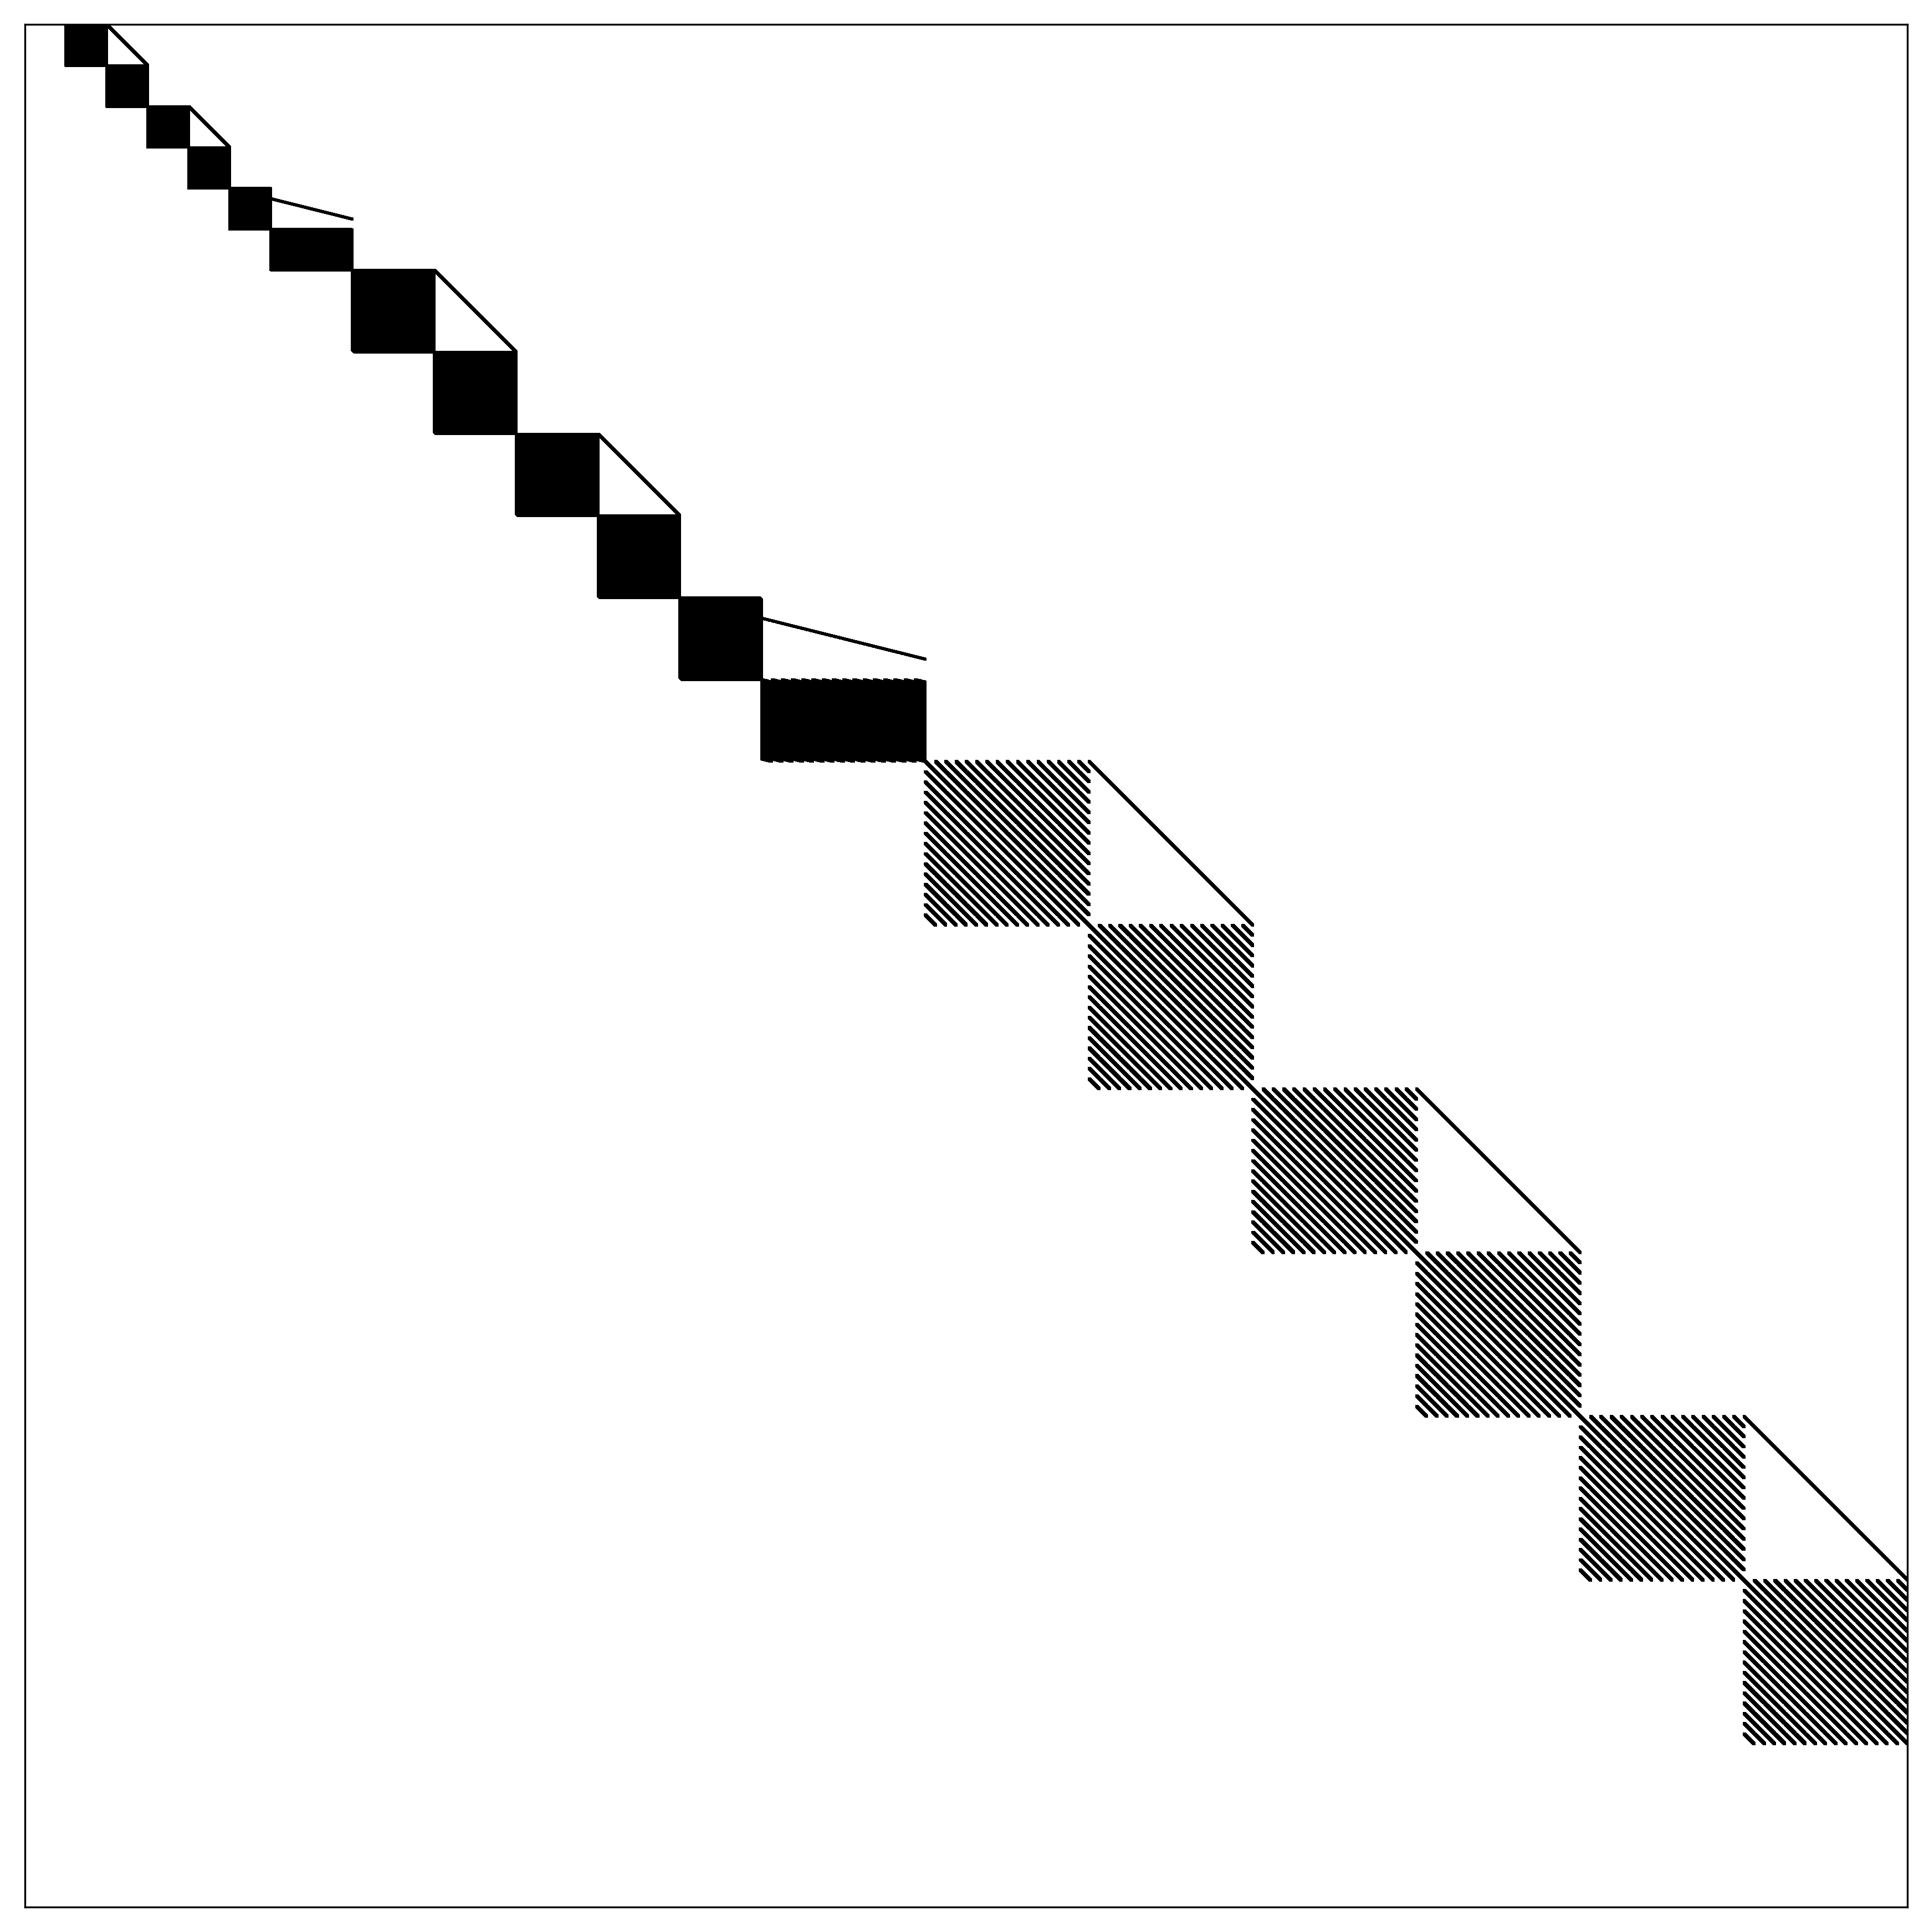

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(15,15), dpi=300)
plt.spy(A, markersize=0.01, color='black')
plt.xticks([], [])
plt.yticks([], [])
plt.show()
plt.savefig("res20.pdf")

In [17]:
M=sp.bmat([[C,D], [A,B]])

In [20]:
A.shape

(188416, 188416)

In [5]:
# get block A
A1,b1 = model.module.seqmodel.blocklist[6].Ab()
A2,b2 = model.module.seqmodel.blocklist[7].Ab()

([], <a list of 0 Text yticklabel objects>)

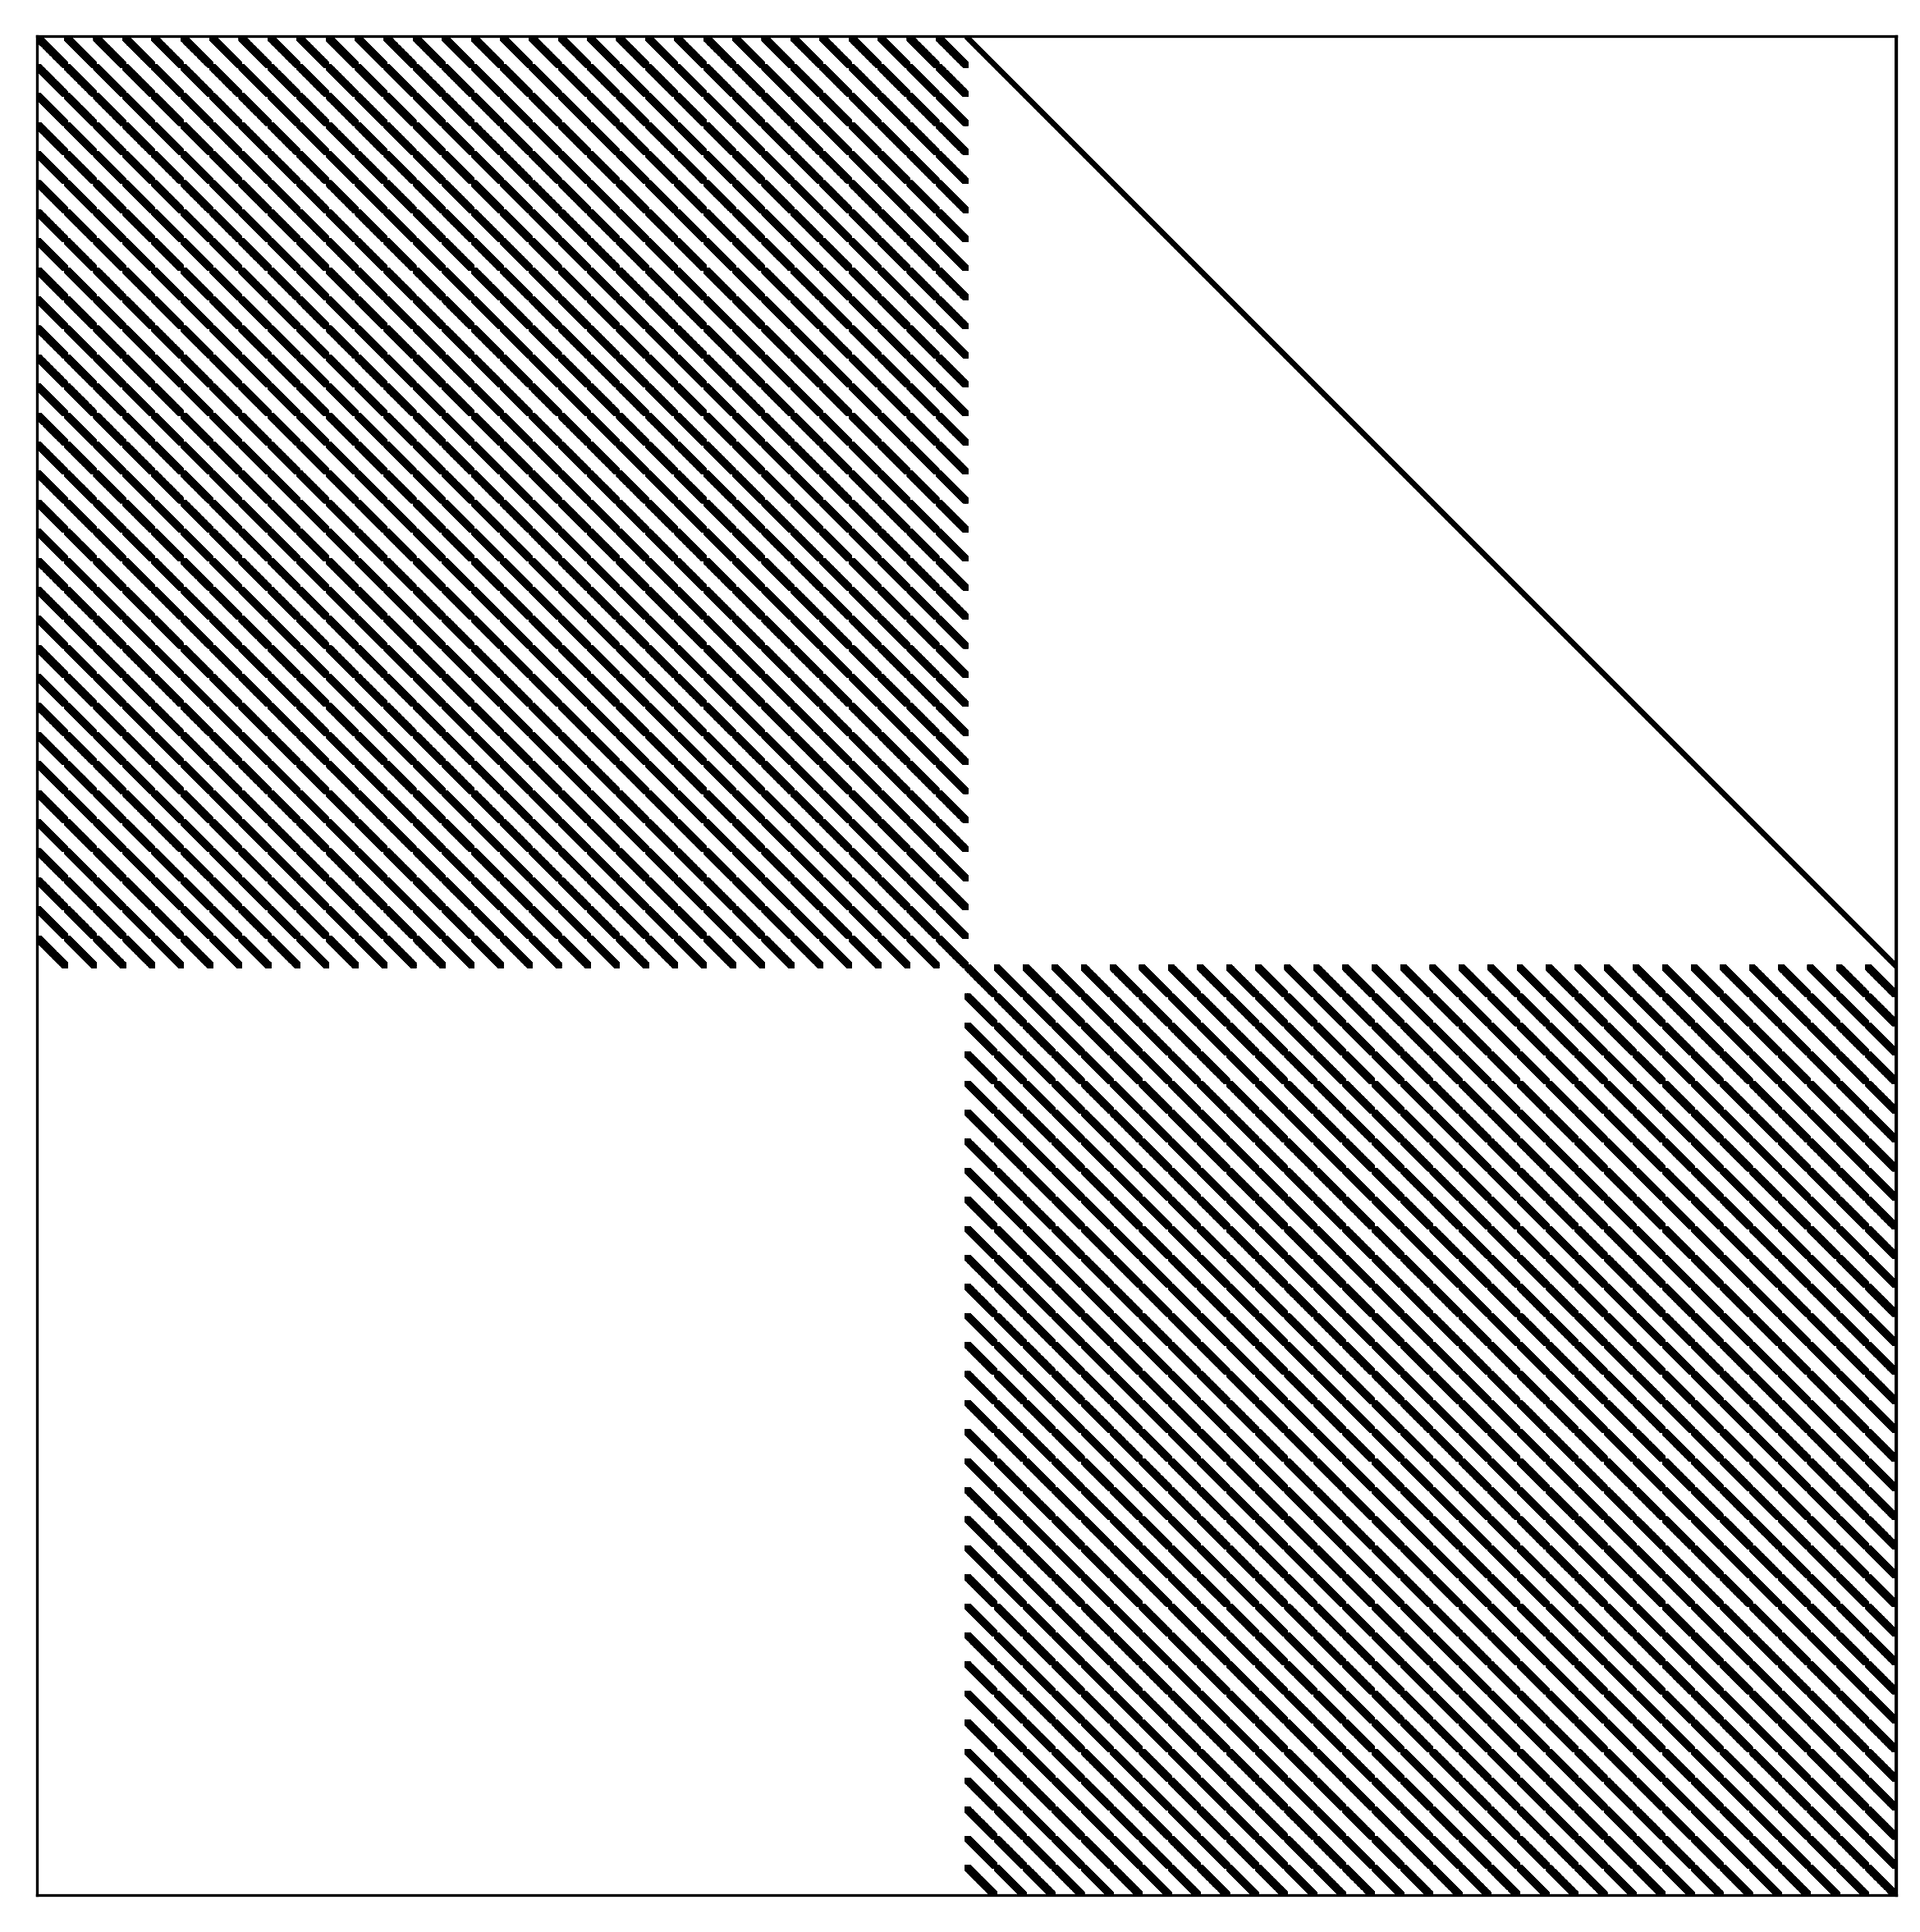

In [14]:
plt.figure(figsize=(10,10), dpi=300)
plt.spy(sp.bmat([[A1,b1]]), markersize=0.01, color='black')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [11]:
plt.show()

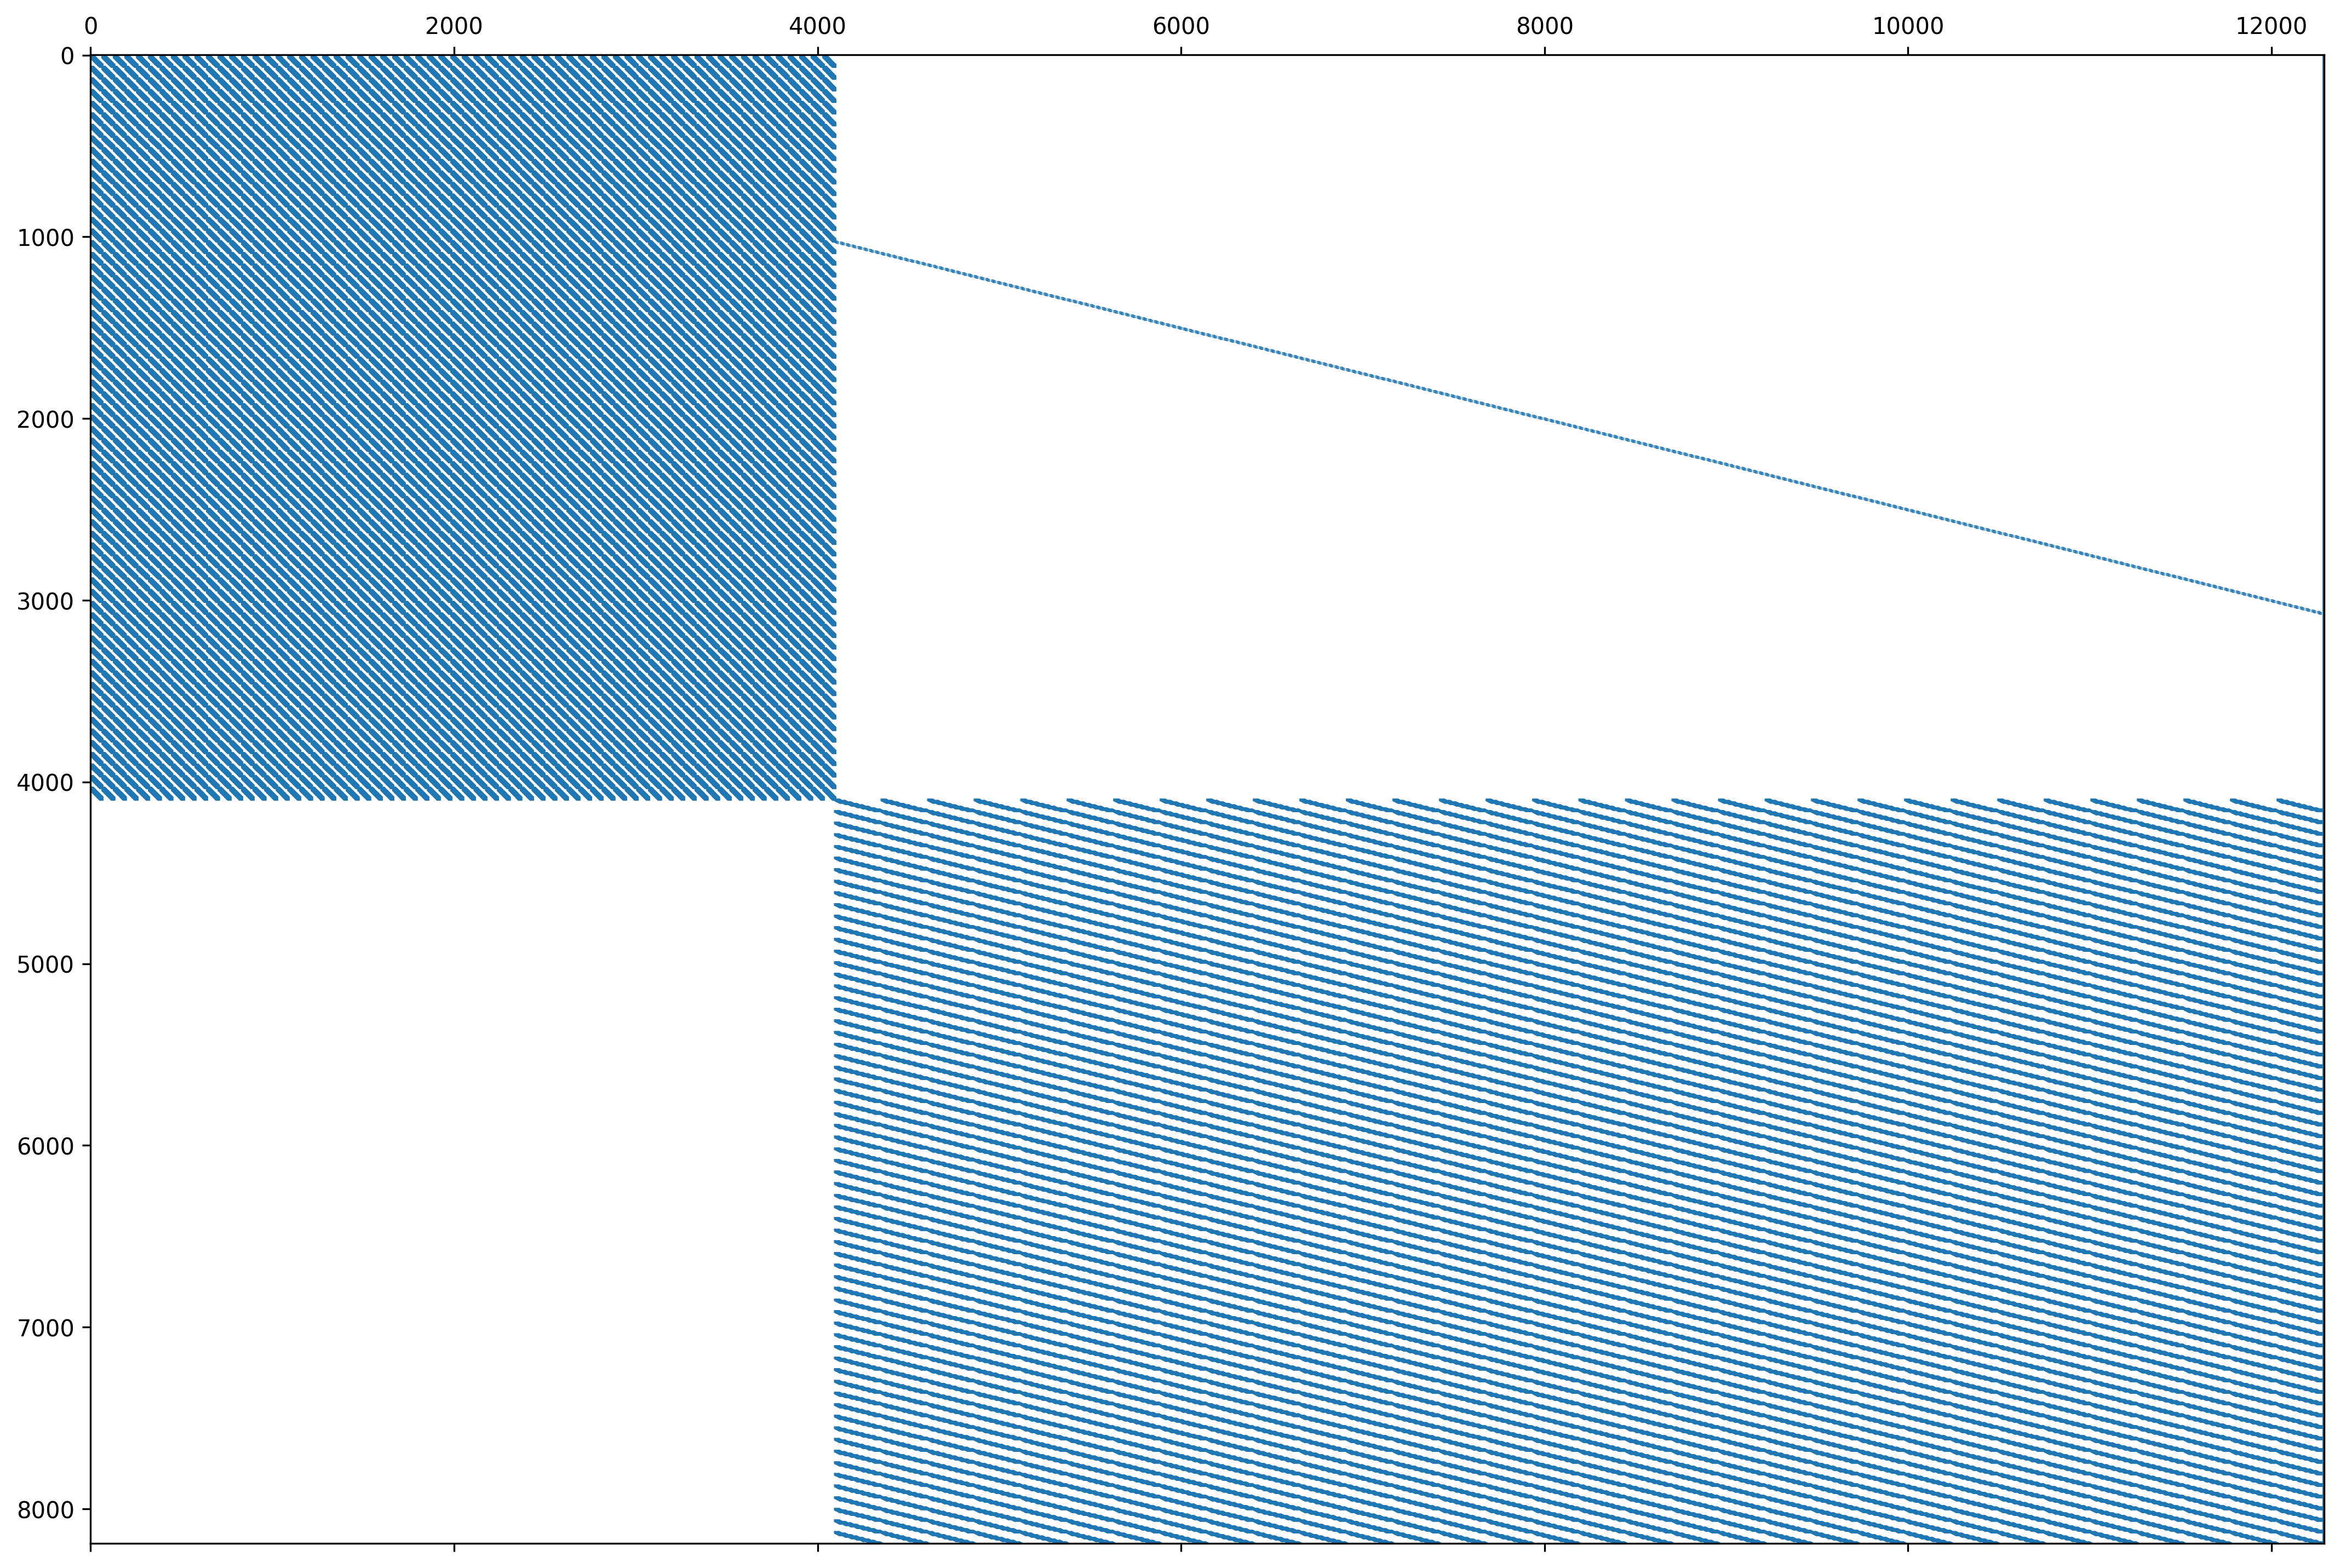

In [8]:
plt.figure(figsize=(18,12), dpi=300)
plt.spy(sp.bmat([[A2,b2]]), markersize=0.01)
plt.show()

In [9]:
# varification
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target
            input_var = input
            target_var = target

            # compute output
            output = model.implicit_forward(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 2 == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))


    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg

criterion = torch.nn.CrossEntropyLoss()

In [10]:
validate(val_loader, model, criterion)

norm diff for the batch: 0.32860222458839417
Test: [0/79]	Time 81.027 (81.027)	Loss 0.2042 (0.2042)	Prec@1 94.531 (94.531)
norm diff for the batch: 0.33881762623786926
norm diff for the batch: 0.3151529133319855
Test: [2/79]	Time 76.486 (78.472)	Loss 0.3014 (0.2534)	Prec@1 92.969 (93.229)
norm diff for the batch: 0.34324926137924194
norm diff for the batch: 0.33497968316078186
Test: [4/79]	Time 77.117 (78.041)	Loss 0.0834 (0.2126)	Prec@1 96.875 (94.219)
norm diff for the batch: 0.32901397347450256
norm diff for the batch: 0.33155739307403564
Test: [6/79]	Time 77.212 (77.639)	Loss 0.2815 (0.2341)	Prec@1 90.625 (93.638)
norm diff for the batch: 0.3514527678489685
norm diff for the batch: 0.33478909730911255
Test: [8/79]	Time 76.849 (77.458)	Loss 0.2668 (0.2364)	Prec@1 91.406 (93.229)
norm diff for the batch: 0.3374708890914917
norm diff for the batch: 0.342547744512558
Test: [10/79]	Time 77.467 (77.437)	Loss 0.3079 (0.2375)	Prec@1 92.969 (93.182)
norm diff for the batch: 0.32100334763526

92.73

In [13]:
# ResNet56
resume = '/home/beeperman/Projects/ImplicitLayers/implicit/validation/save_temp/ResNet56model.th'
model = ResNetModel([9,9,9])

INFO: <function FlattenOpL.__init__.<locals>.<lambda> at 0x7fda98a98e60> is not a torch Module


In [14]:
print("=> loading checkpoint '{}'".format(resume))
checkpoint = torch.load(resume)
model = ModelWrapper(model)
model.load_state_dict(checkpoint['state_dict'], strict=True)
print("=> loaded checkpoint")

=> loading checkpoint '/home/beeperman/Projects/ImplicitLayers/implicit/validation/save_temp/ResNet56model.th'
=> loaded checkpoint


In [15]:
# get A,B,C,D,phi
model.eval()
for xs, ys in val_loader:
    model.module.seqmodel.populate_C = True
    A,B,C,D,phi = model.module.seqmodel.getImplicitModel(xs[0:1, :])
    break

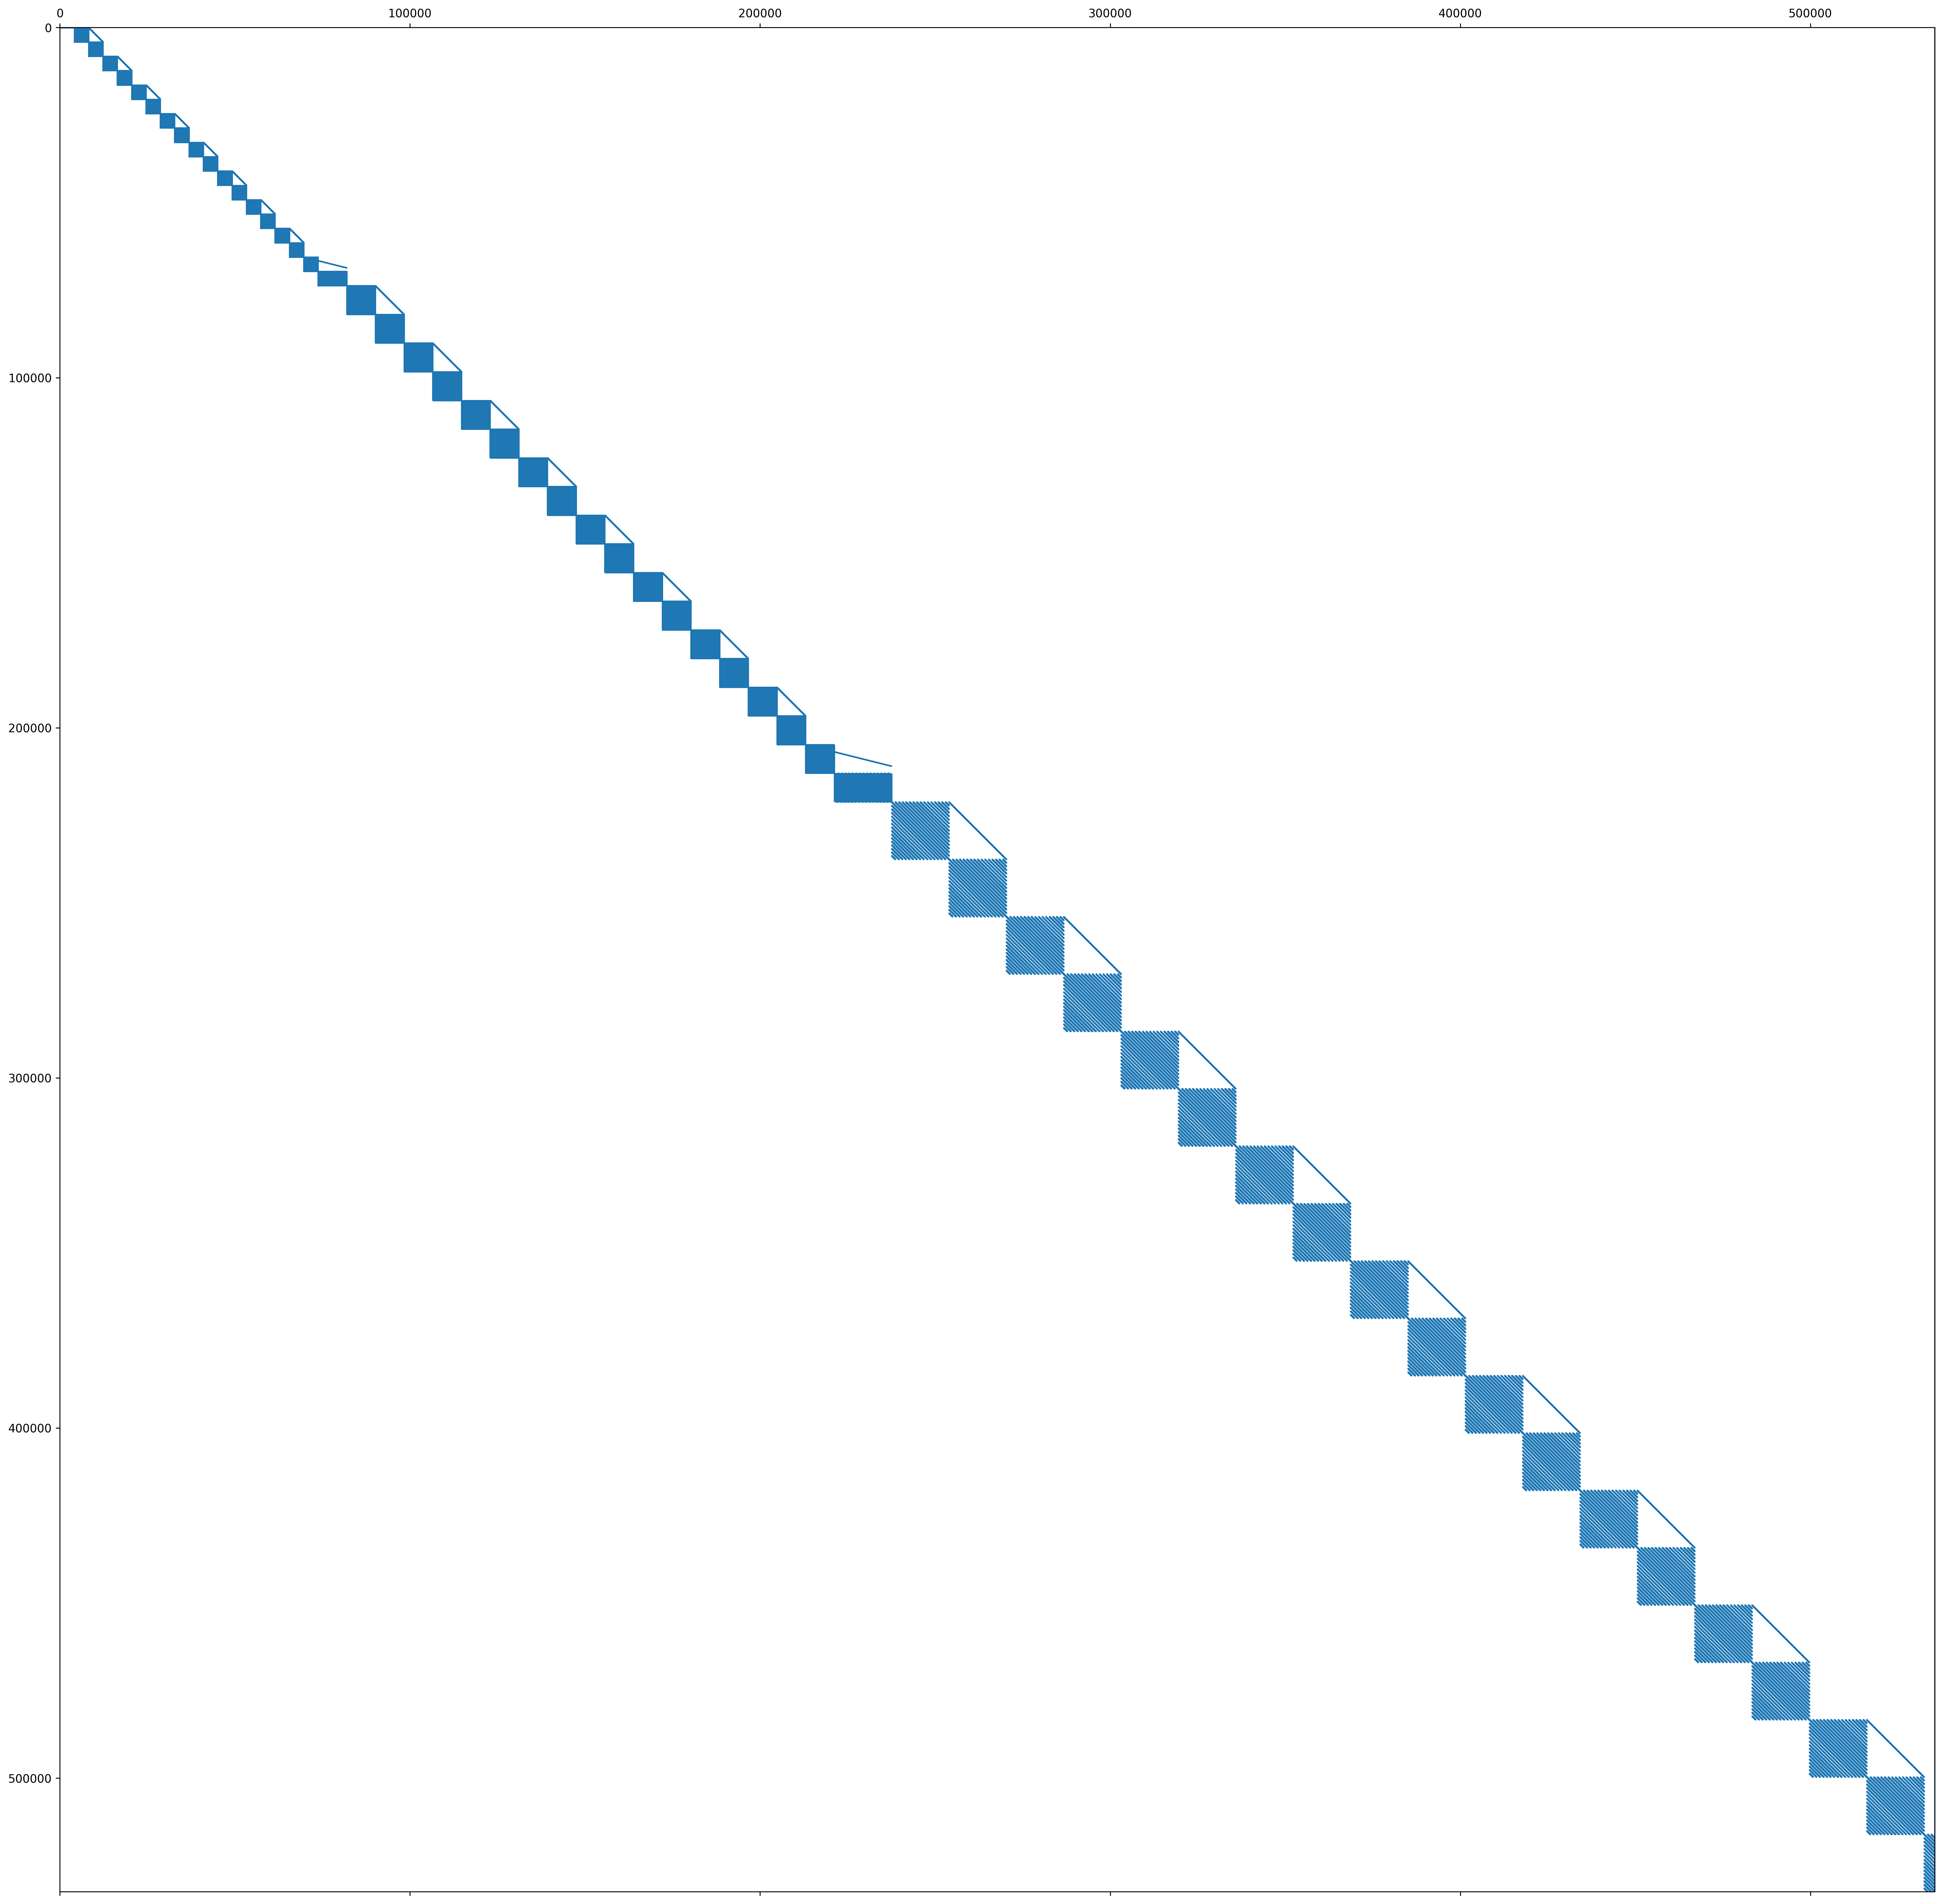

In [16]:
plt.figure(figsize=(30,30), dpi=300)
plt.spy(sp.bmat([[C,D], [A,B]]), markersize=0.01)
plt.show()

In [17]:
# get block A
A1,b1 = model.module.seqmodel.blocklist[18].Ab()
A2,b2 = model.module.seqmodel.blocklist[19].Ab()

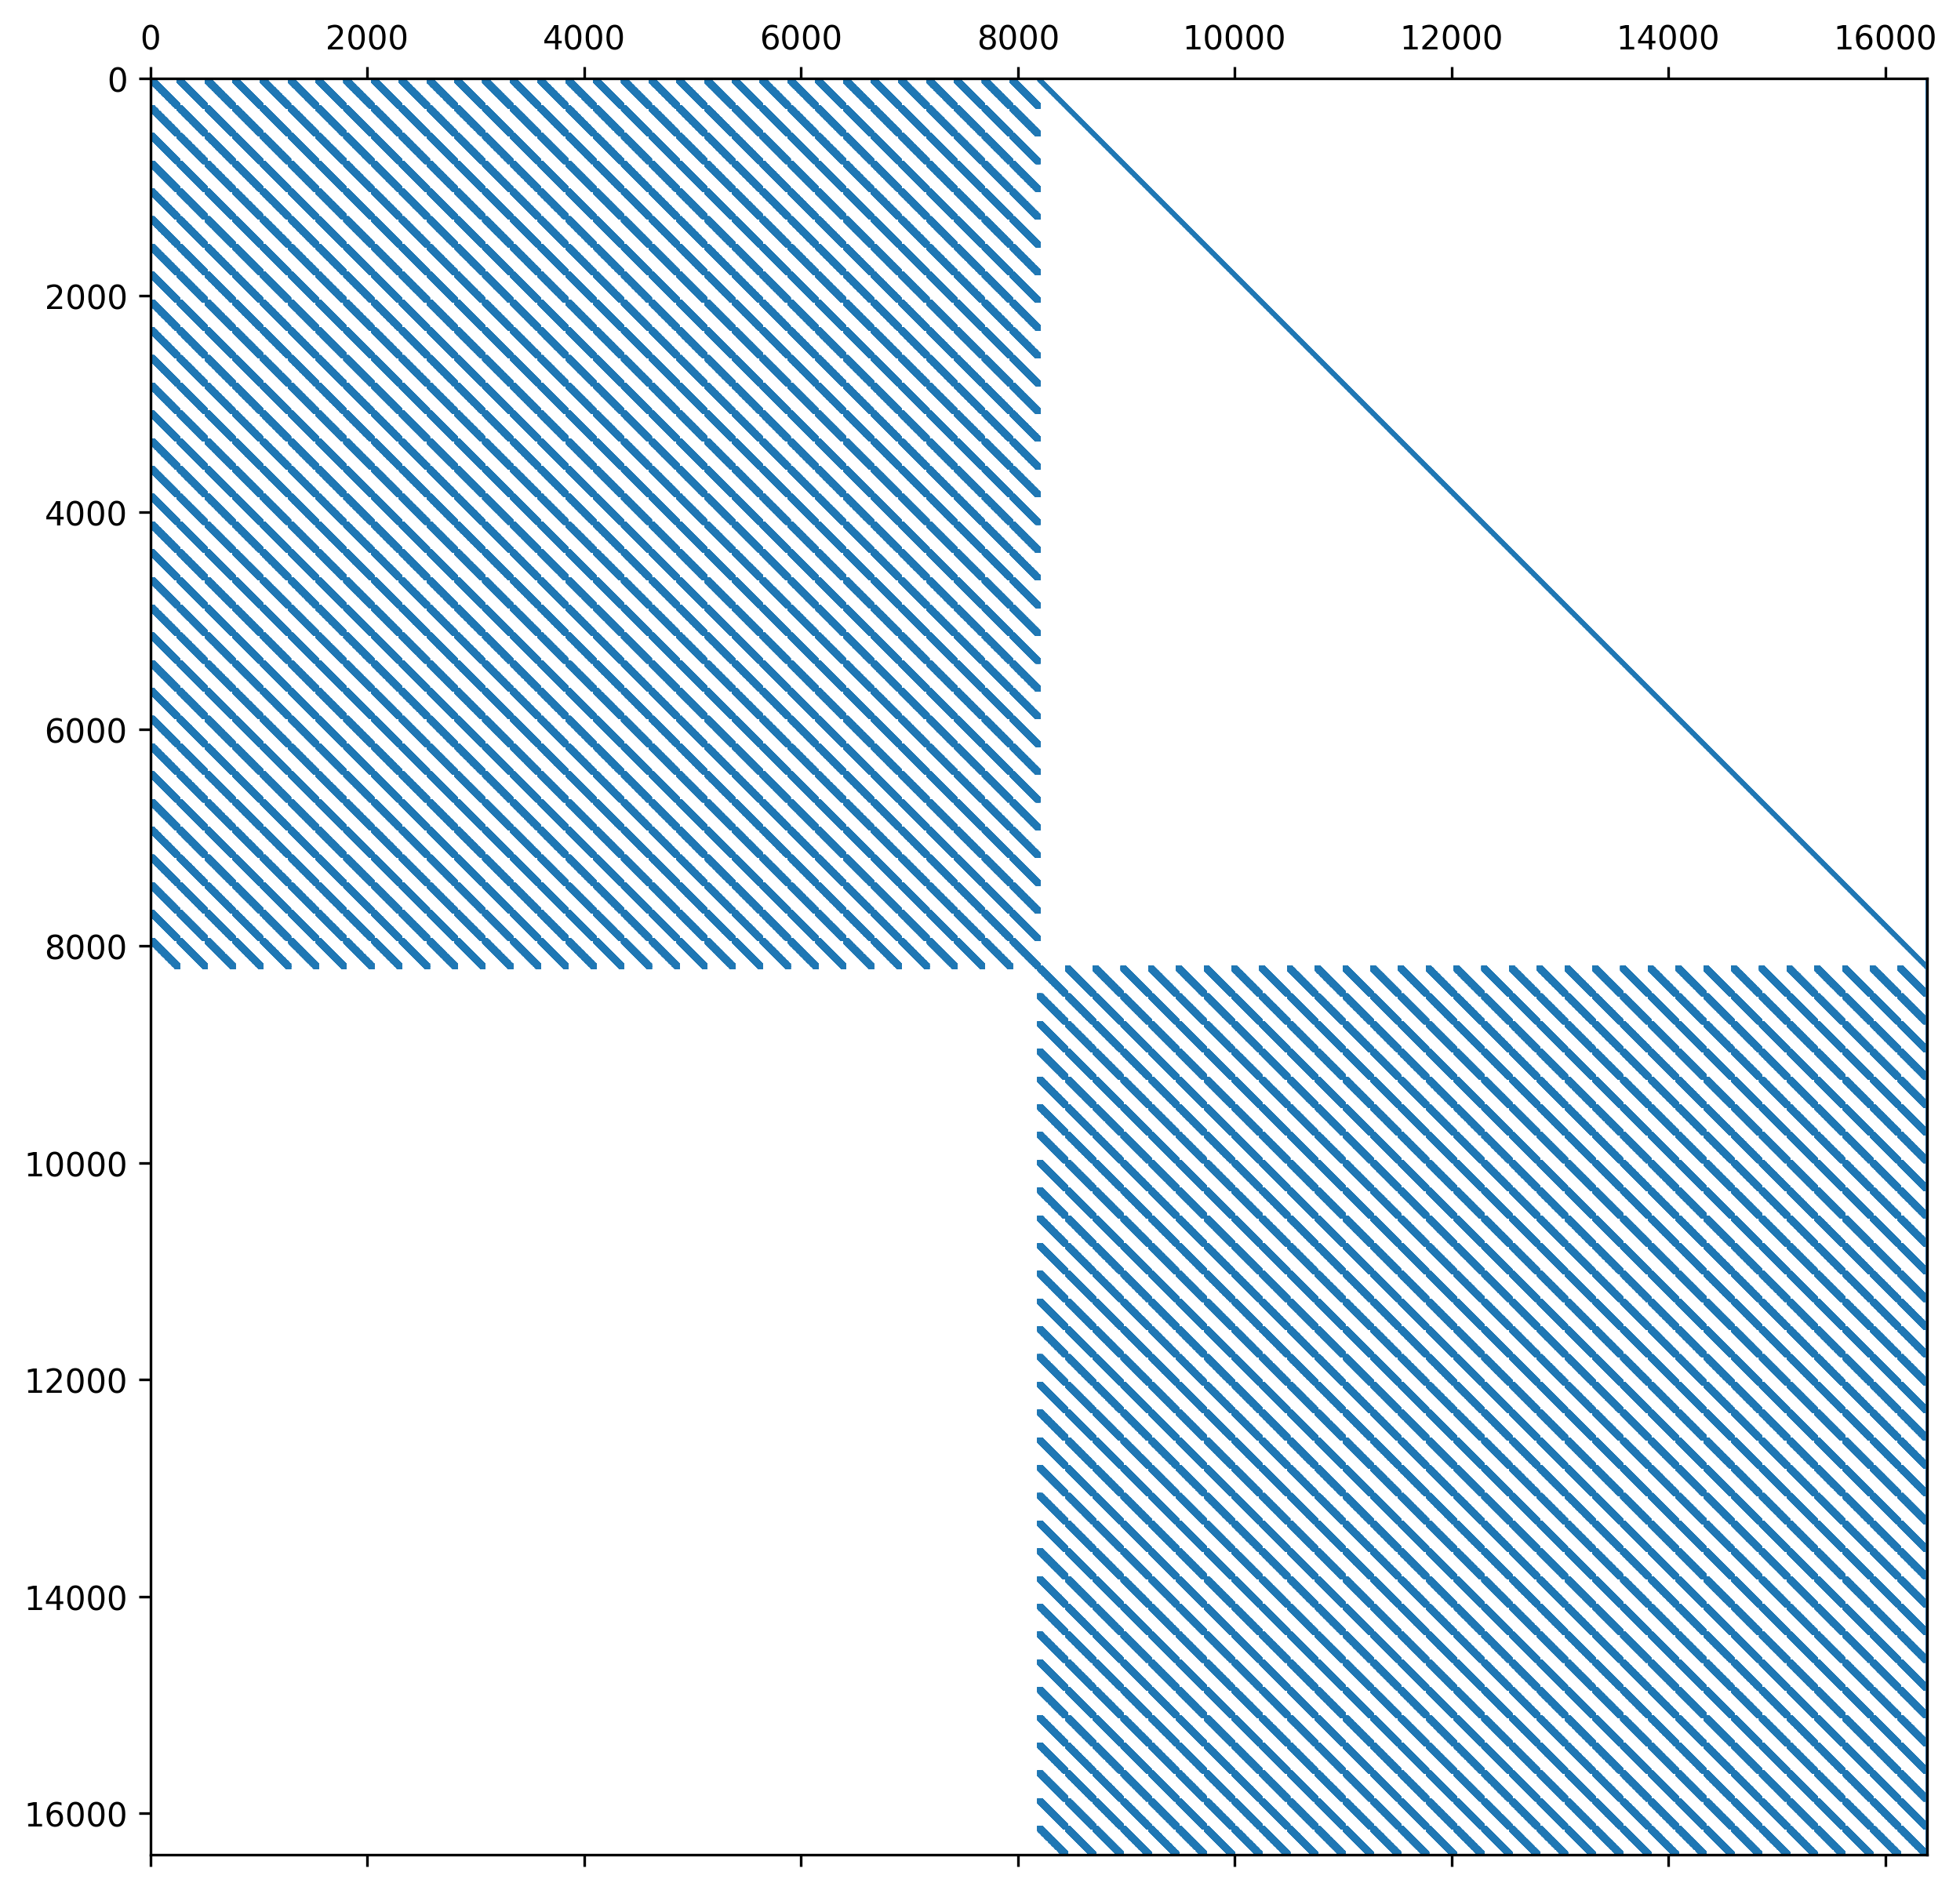

In [18]:
plt.figure(figsize=(10,10), dpi=300)
plt.spy(sp.bmat([[A1,b1]]), markersize=0.01)
plt.show()

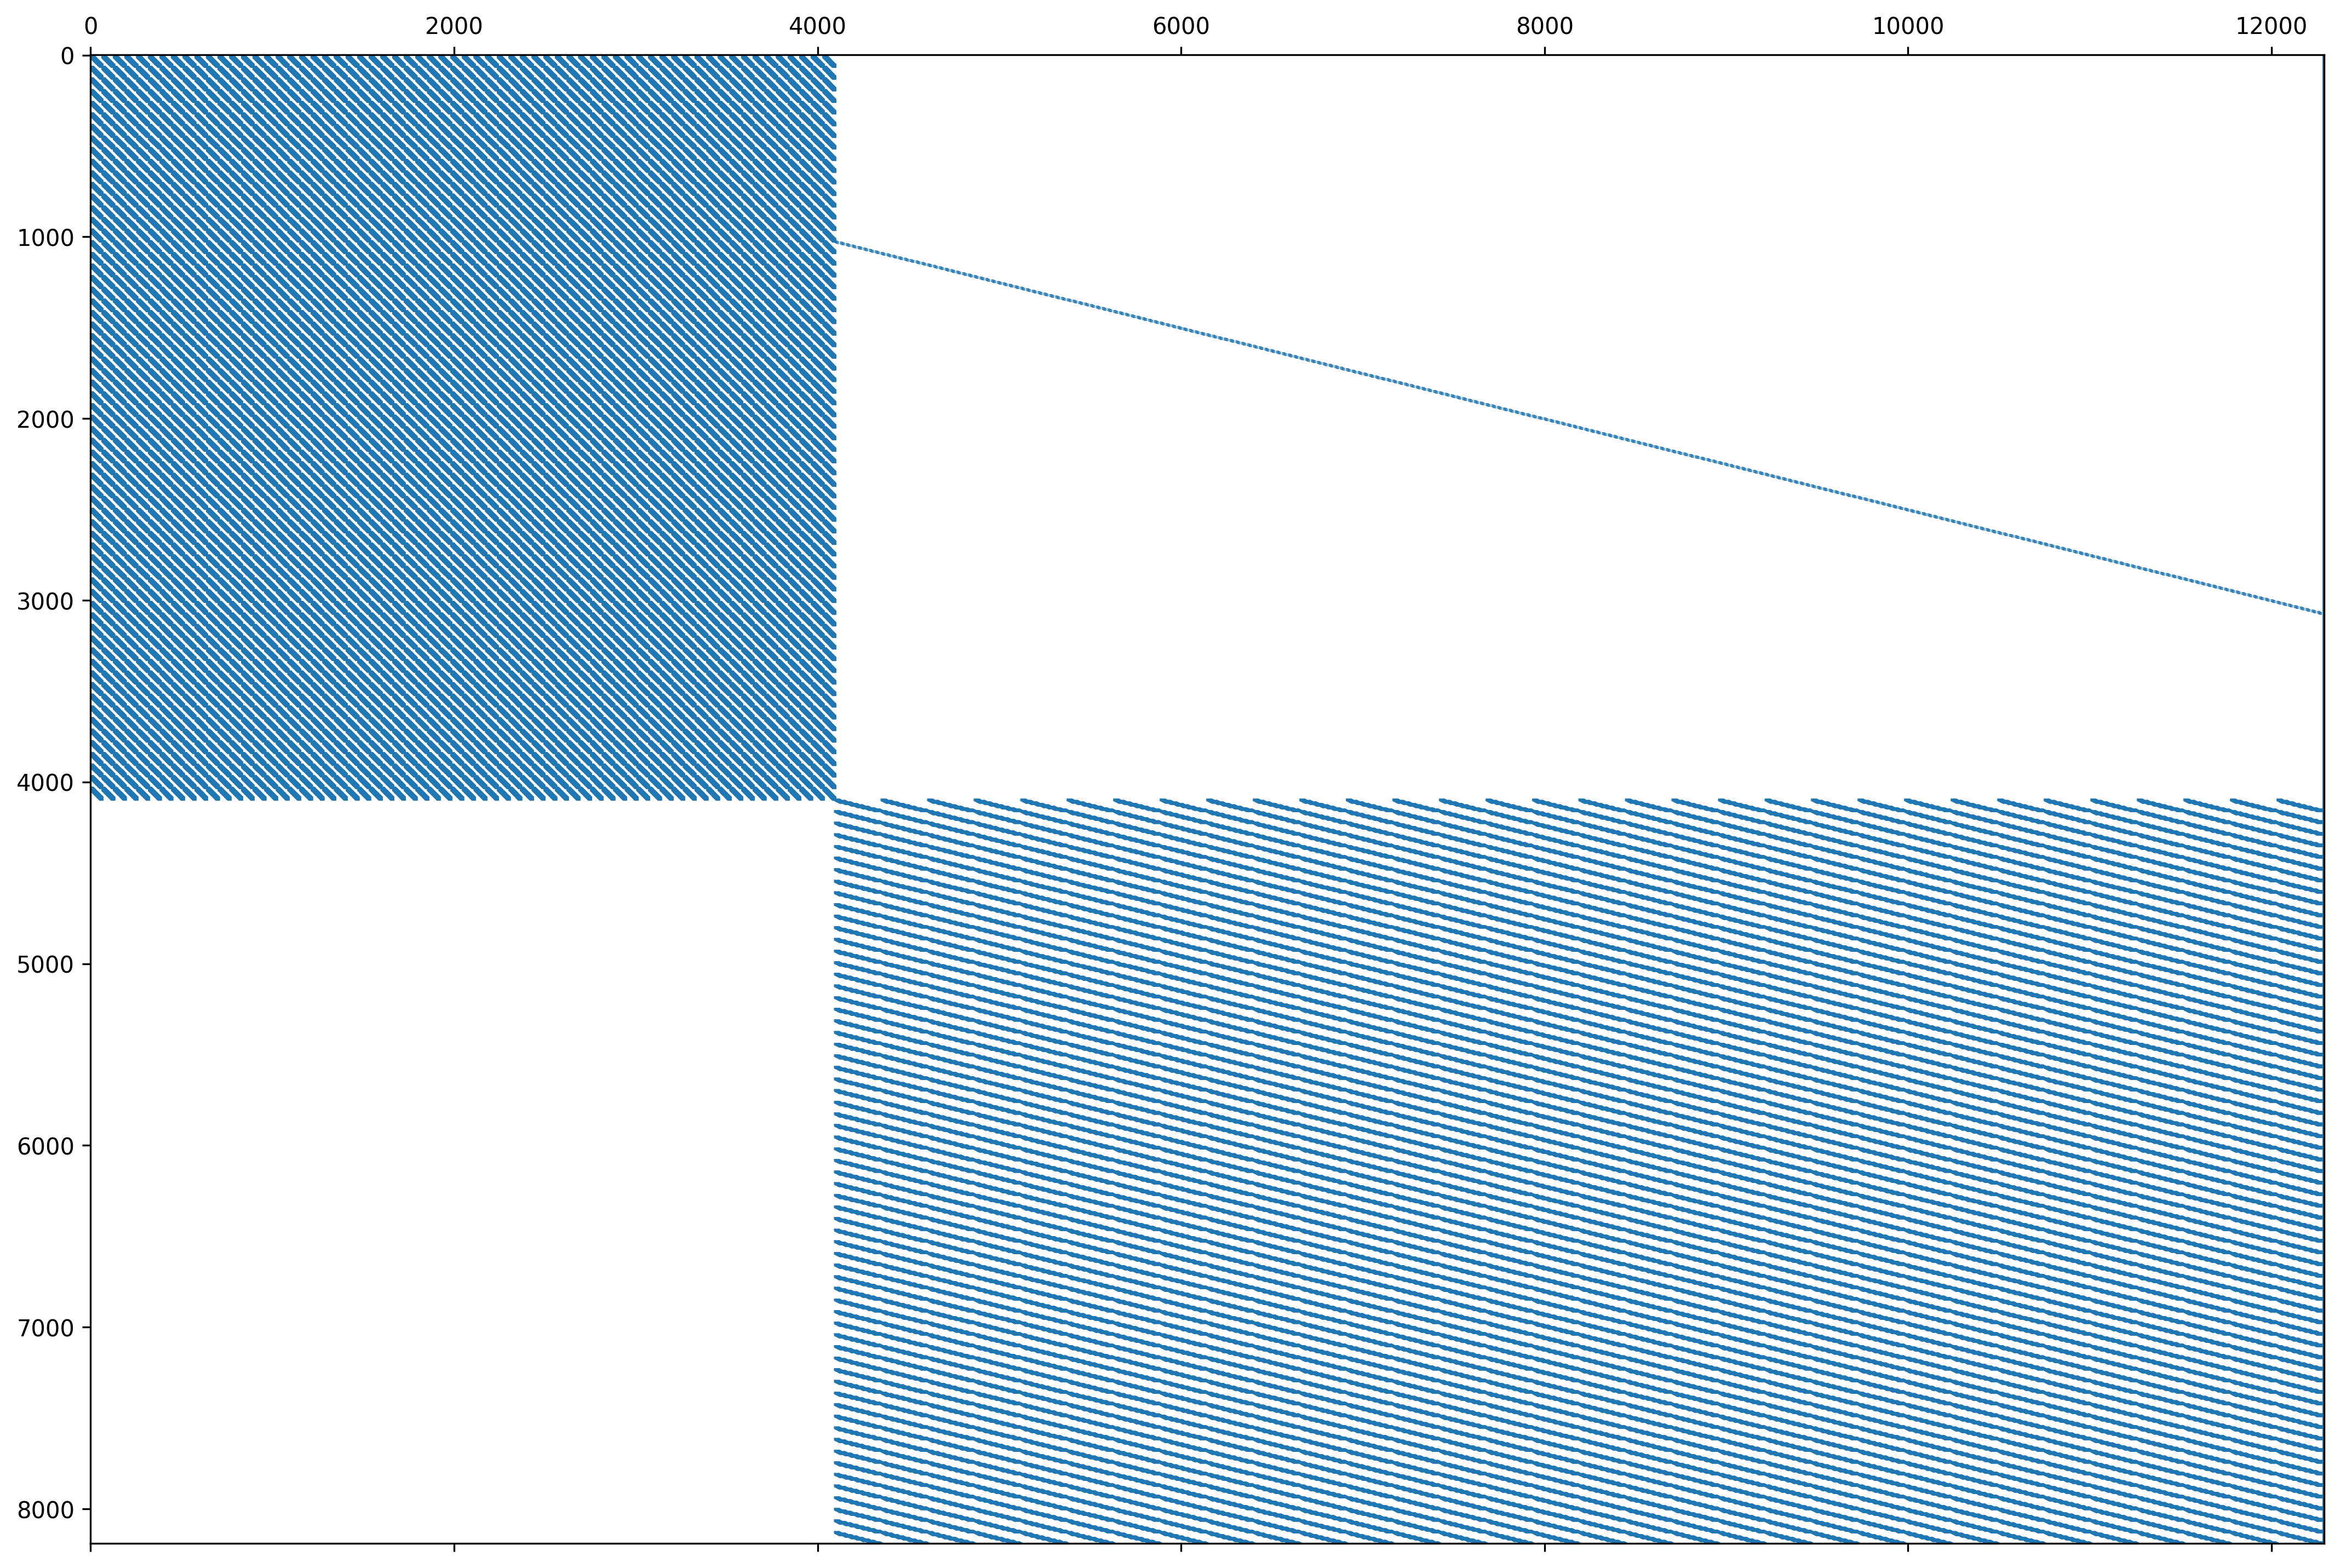

In [19]:
plt.figure(figsize=(18,12), dpi=300)
plt.spy(sp.bmat([[A2,b2]]), markersize=0.01)
plt.show()

In [21]:
validate(val_loader, model, criterion)

norm diff for the batch: 0.8491262793540955
Test: [0/79]	Time 561.325 (561.325)	Loss 0.3035 (0.3035)	Prec@1 94.531 (94.531)
norm diff for the batch: 0.7808387875556946
norm diff for the batch: 0.8268041610717773
Test: [2/79]	Time 562.943 (563.248)	Loss 0.1964 (0.2694)	Prec@1 92.969 (94.010)
norm diff for the batch: 0.7705764174461365
norm diff for the batch: 0.7572755813598633
Test: [4/79]	Time 563.378 (563.103)	Loss 0.0713 (0.2260)	Prec@1 98.438 (95.156)
norm diff for the batch: 0.8213461637496948
norm diff for the batch: 0.8482509851455688
Test: [6/79]	Time 563.383 (562.915)	Loss 0.4138 (0.3047)	Prec@1 89.844 (93.862)
norm diff for the batch: 0.7359616756439209
norm diff for the batch: 0.7820941209793091
Test: [8/79]	Time 565.450 (563.785)	Loss 0.3223 (0.2911)	Prec@1 91.406 (93.490)
norm diff for the batch: 0.7272207736968994
norm diff for the batch: 0.7494626641273499
Test: [10/79]	Time 559.841 (563.407)	Loss 0.3052 (0.3010)	Prec@1 93.750 (93.466)
norm diff for the batch: 0.75799673

93.01